# Hito 3: Corona virus (Covid-19)

## Presentación

Somos el equipo conformado por Raúl Cid, José Espina, Michelle Valenzuela y Alejandro Veragua. Nuestro *dataset* corresponde al [publicado en el portal Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) construido y mantenido por la Universidad John Hopkins, al igual que para el hito 1

## Comentarios sobre el hito 1

Se realizó un análisis exploratorio, donde descubrimos varios datos inconsistentes y outliers
Se buscaron correlaciones contra atributos como el ingreso per cápita, la temperatura, el índice de pobreza de los diferentes países, pero sin éxito. Finalmente se realizó una prueba de concepto de clústering a partir de los coeficientes de un modelo de regeresión polinomial donde sí aparecieron resultados interesantes

## Propuesta del hito 3
Considerando que los polinomios hacen "overfitting" cuando el grado es muy alto, como el ejercicio realizado en el hito 1, aprovecharemos hacer algo similar, con la diferencia de usar un modelo auto-regresivo y hacer clustering sobre los coeficientes que resulten del modelo. En particular, quisimos experimentar con un modelo auto-regresivo con media móvil (ARMA). Como se tienen datos sólo de los últimos meses y el virus es nuevo, los datos no son estacionarios (o no hay suficientes datos para demostrar que lo son), por lo que usaremos una variante llamada ARIMA (donde la "i" hace referencia a la integración), que permite encontrar las diferencias no-estacionarias para lograr la estacionariedad (https://www.statisticshowto.com/arma-model/)

## Metodología de trabajo para el hito 3
* se preprocesaron los datos, removiendo los datos outliers, ya que descubrimos en el hito 1 que hay paises con datos demasiado alejados de la tendencia central

Además, se refuerza la idea de 2 artículos publicados que usan el mismo acercamiento
1) Benvenuto, D., Giovanetti, M., Vassallo, L., Angeletti, S., & Ciccozzi, M. (2020). Application of the ARIMA model on the COVID-2019 epidemic dataset. Data in brief, 105340.
2) Yang, Q., Wang, J., Ma, H., & Wang, X. (2020). Research on COVID-19 Based on ARIMA ModelΔ—Taking Hubei, China as an example to see the epidemic in Italy. Journal of Infection and Public Health.

NOTA IMPORTANTE: Para ejecutar este notebook, se necesitan scikit, matplotlib, numpy y statsmodels. Éste último para poder aplicar el modelo ARIMA. Se debe instalar con pip en el ambiente del libro:

$ pip install statsmodels

o con conda:

$ conda install -c conda-forge statsmodels

(https://www.statsmodels.org/stable/install.html)

NOTA IMPORTANTE 2: Calcular el modelo ARIMA toma un tiempo de cómputo importante

En detalle, el plan es:

* Calcular ARIMA para todos los países


## Configuración base del notebook
El bloque a continuación configura el libro, definiendo funciones y cargando las fuentes de datos

In [1]:
# Librería de álgebra lineal
import numpy as np 
# Procesamiento de datos y carga de archivos CSV
import pandas as pd
# Librearía gráfica
import matplotlib.pylab as plt
# Librería para usar recursos del sistema operativo
import os 
# Librearía usada para extraer el nombre del archivo de cada path
import ntpath
# Librería gráfica
import seaborn as sns
# Librearía para usar herramientas relacionadas con
# aprendizaje máquina. Se usó para preprocesar y
# calcular regresión
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Colores
from matplotlib import colors
# Ticker
import matplotlib.ticker as ticker
# Animation
import matplotlib.animation as animation
# Arima
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
# Configuración general
%load_ext autoreload
%autoreload 2

# Matplotlib inline
%matplotlib notebook
%matplotlib inline

# Se prepara carga de los archivos del dataset
paths = []
for dirname, _, filenames in os.walk('./novel-corona-virus-2019-dataset'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path);
dataFrames = {}
for path in paths:
    dataFrames[ntpath.basename(path)] = pd.read_csv(path)

# Carga y reduce de datos por dia

In [488]:
from atributos_extra.correccion_nombres import cargar_correccion, atributos_extra
covid19Data = dataFrames['covid_19_data.csv'].copy()
dict_error, dict_pares = cargar_correccion()
group_covid_data, paises_covid_df = atributos_extra(covid19Data, dict_error)
group_covid_data.columns = group_covid_data.columns.droplevel(1)
group_covid_data['ObservationDate'] = pd.to_datetime(group_covid_data['ObservationDate'])
group_covid_data.set_index('Country/Region', inplace=True)
group_covid_data.set_index('ObservationDate', inplace=True, append=True)
group_covid_data.drop('Last Update', axis=1, inplace=True)

In [489]:
group_covid_data.loc['Chile']

,SNo,Confirmed,Deaths,Recovered
ObservationDate,,,,
2020-03-03,3199,1.0,0.0,0.0
2020-03-04,3358,1.0,0.0,0.0
2020-03-05,3488,4.0,0.0,0.0
2020-03-06,3671,4.0,0.0,0.0
2020-03-07,3876,4.0,0.0,0.0
...,...,...,...,...
2020-07-16,1109460,323698.0,7290.0,295301.0
2020-07-17,1121911,326439.0,8347.0,296814.0
2020-07-18,1134518,328846.0,8445.0,299449.0


# Calcular fenomeno por dia, basado en acumulados

In [490]:
import datetime
def apply_primer_dia(data):
    date_inicio_dataset = pd.to_datetime('22/01/2020') #datetime.date(2020,1,22)
    #data = data.sort_index(ascending=True, level=0)
    observation_date = data.index.get_level_values(1)
    
    num_dia_desde_primer_caso = 0
    data[ 'num_dia_desde_22_enero'] = observation_date - date_inicio_dataset
    
    fecha_primer_caso = observation_date.min()
    data['num_dia_desde_primer_caso'] = observation_date - fecha_primer_caso
    # Set indexed
    data.set_index('num_dia_desde_primer_caso', inplace=True, append=True)
    # data.set_index('num_dia_desde_22_enero', inplace=True, append=True)
    data.reset_index(level=1, inplace=True)
    return data

def compute_diff(col):
    diff = col - col.shift(periods=1)
    diff[0] = col[0]
    # print(col[10])
    # print(diff[9])
    # print(20*'-')
    return diff

def apply_por_dia(data):
    data['num_confirmados'] = compute_diff(data['Confirmed'])
    data['num_recuperados'] = compute_diff(data['Recovered'])
    data['num_fallecidos'] = compute_diff(data['Deaths'])
    return data

data = (
    group_covid_data
        .groupby('Country/Region')
        .apply(lambda country: apply_primer_dia(country))
        .droplevel(1)
        .groupby(level=0)
        .apply(lambda country: apply_por_dia(country))
)

data.loc['Chile'].sort_index(ascending=False).head(5)

,ObservationDate,SNo,Confirmed,Deaths,Recovered,num_dia_desde_22_enero,num_confirmados,num_recuperados,num_fallecidos
num_dia_desde_primer_caso,,,,,,,,,
139 days,2020-07-20,1159746,330930.0,8503.0,301794.0,180 days,0.0,0.0,0.0
138 days,2020-07-19,1147132,330930.0,8503.0,301794.0,179 days,2084.0,2345.0,58.0
137 days,2020-07-18,1134518,328846.0,8445.0,299449.0,178 days,2407.0,2635.0,98.0
136 days,2020-07-17,1121911,326439.0,8347.0,296814.0,177 days,2741.0,1513.0,1057.0
135 days,2020-07-16,1109460,323698.0,7290.0,295301.0,176 days,2493.0,3216.0,104.0


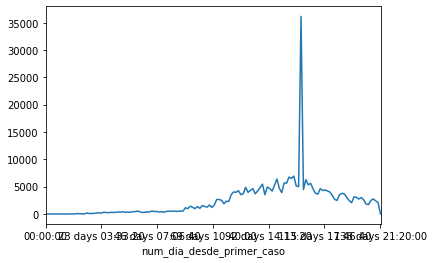

In [464]:
data.loc['Chile']['num_confirmados'].plot()

### Preproceso: Outliers
Como parte del preprocesamiento, se realiza el siguiente tratamiento a los datos: Para cada país, se revisan las columnas de confirmados, fallecidos y recuperados. En cada una de ellas se buscan outliers, en este caso, valores que superen en magnitud al percentil 99 o que sean menores a cero. Estos se transorman a NaN y luego interpolamos los datos para llenar estos espacios.
Además, se debe recalcular la cantidad acumulada por día para cada columna.

In [77]:
def remove_outliers(dset_base, cols=['num_confirmados', 'num_fallecidos', 'num_recuperados']):  
    for pais in dset_base['Country/Region'].unique():
        for col in cols:
            pais_col = dset_base[dset_base['Country/Region']==str(pais)][col]
            changed_values = pd.Series(np.nan, index=pais_col.index)
            for value in pais_col.iteritems():
                if value[1] > pais_col.quantile(.99) or value[1] < 0:
                    changed_values[value[0]] = np.nan
                else:
                    changed_values[value[0]] = value[1]
            changed_values.interpolate(inplace=True)
            acc = changed_values.cumsum()
            dset_base.loc[(dset_base['Country/Region']==pais), col] = changed_values
            dset_base.loc[(dset_base['Country/Region']==pais), str('acc') + col[3:]] = acc
    return dset_base

In [491]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers(col, q=0.99):
    threshold = col.mean() + 3*col.std()
    # threshold = col.quantile(q)
    col[(col >= threshold)  | (col < 0)] = np.nan
    # col[(col >= col.quantile(q)) | (col < 0)] = np.nan
    #print(col.name, col.isna().sum())
    res = col.interpolate()
    return res

def apply_remove_outliers(pais_col, cols=['num_confirmados', 'num_recuperados']):
    # print(pais_col.name)
    pais_col[cols] = pais_col[cols].apply(lambda x: remove_outliers(x))
    # print(pais_col[cols].isna().sum())
    return pais_col

def compute_acumulados(pais_col):
    pais_col['Confirmed'] = pais_col['num_confirmados'].cumsum()
    pais_col['Recovered'] = pais_col['num_recuperados'].cumsum()
    pais_col['Deaths'] = pais_col['num_fallecidos'].cumsum()
    pais_col = pais_col.rename(
        columns={
            'Confirmed': 'acc_confirmados',
            'Recovered': 'acc_recuperados',
            'Deaths': 'acc_fallecidos'
        }
    )
    return pais_col
# data = data.drop('Papua New Guinea')
res = (
    data
        .groupby(level=0)
        .apply(lambda pais_col: apply_remove_outliers(pais_col))
    )

# Laos tiene un outliers que por alguna razon no se imputa
res.loc['Laos', '0'] = data.loc['Laos', '0']
# Calculamos los acumulados
res = (res
    .groupby(level=0)
    .apply(lambda pais_col: compute_acumulados(pais_col))
    )

In [498]:
res.loc['Chile'].sort_index(level=0, ascending=False).head(5)

,ObservationDate,SNo,acc_confirmados,acc_fallecidos,acc_recuperados,num_dia_desde_22_enero,num_confirmados,num_recuperados,num_fallecidos
num_dia_desde_primer_caso,,,,,,,,,
139 days,2020-07-20,1159746,299495.0,8503.0,233926.5,180 days,0.0,0.0,0.0
138 days,2020-07-19,1147132,299495.0,8503.0,233926.5,179 days,2084.0,2345.0,58.0
137 days,2020-07-18,1134518,297411.0,8445.0,231581.5,178 days,2407.0,2635.0,98.0
136 days,2020-07-17,1121911,295004.0,8347.0,228946.5,177 days,2741.0,1513.0,1057.0
135 days,2020-07-16,1109460,292263.0,7290.0,227433.5,176 days,2493.0,3216.0,104.0


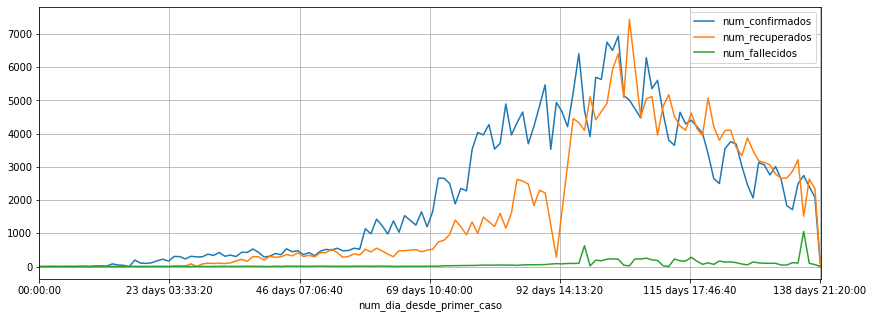

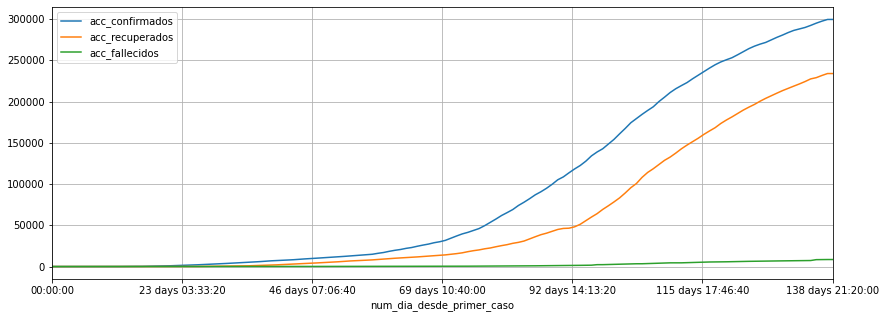

In [507]:
figsize = (14, 5)
res.loc['Chile'][['num_confirmados', 'num_recuperados', 'num_fallecidos']].plot(figsize=figsize, grid=True)
res.loc['Chile'][['acc_confirmados', 'acc_recuperados', 'acc_fallecidos']].plot(figsize=figsize, grid=True)


## Polinomial features

In [620]:
from sklearn.preprocessing import PolynomialFeatures
def ajuste_polinomial(X, y=None, degree=8):
    """
    X es el dia que ha transcurrido desde el primer contagio
    y es el numero de contagiados, fallecidos y/o recuperados
    """
    
    poly_reg = PolynomialFeatures(degree=degree)
    values = np.array([X.index.days.values, X['acc_confirmados'].values]).T
    poly_reg.fit_transform(values)
    return poly_reg.transform(values), poly_reg

pol, poly_reg = ajuste_polinomial(res.loc['Chile'])
res.loc['Chile'].index.days.values.shape

(140,)

In [624]:
pol.shape

(140, 45)

In [606]:
poly_reg.get_feature_names()

['1',
 'x0',
 'x1',
 'x0^2',
 'x0 x1',
 'x1^2',
 'x0^3',
 'x0^2 x1',
 'x0 x1^2',
 'x1^3',
 'x0^4',
 'x0^3 x1',
 'x0^2 x1^2',
 'x0 x1^3',
 'x1^4',
 'x0^5',
 'x0^4 x1',
 'x0^3 x1^2',
 'x0^2 x1^3',
 'x0 x1^4',
 'x1^5',
 'x0^6',
 'x0^5 x1',
 'x0^4 x1^2',
 'x0^3 x1^3',
 'x0^2 x1^4',
 'x0 x1^5',
 'x1^6',
 'x0^7',
 'x0^6 x1',
 'x0^5 x1^2',
 'x0^4 x1^3',
 'x0^3 x1^4',
 'x0^2 x1^5',
 'x0 x1^6',
 'x1^7',
 'x0^8',
 'x0^7 x1',
 'x0^6 x1^2',
 'x0^5 x1^3',
 'x0^4 x1^4',
 'x0^3 x1^5',
 'x0^2 x1^6',
 'x0 x1^7',
 'x1^8']

In [535]:

(
    data.loc[['Chile', 'US']]
    .groupby(level=0)
    .apply(lambda x: ajuste_polinomial(x))
)

KeyboardInterrupt: 

## Modelo ARIMA
Usamos un modelo ARIMA p=5,d=1,q=0. El detalle de estos parámetros se explica a continuación (basado en https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

* El parámetro "p" es el número de observaciones pasadas que considera el modelo. También se le llama "orden". Usamos  14 debido a que es el tiempo que demora una persona es saber que tiene el virus, considerando tiempos de síntomas y resultado del exámen. Además, 14 días es el tiempo que dura la cuarentena para las personas con resultado positivo en su exámen
* El parámetro "d" es el grado de diferenciación. Esto se usa para generar estacionariedad en series no estacionarias
* El parámetro "q" es el tamaño de la media móvil para el error de los datos anteriores

In [ ]:
# Se calculan coeficientes del ARIMA por país. Si ya está calculado se lee el csv
dframe_arima = None
if os.path.isfile('arima_coefs.csv') :
    dframe_arima = pd.read_csv('arima_coefs.csv')
else :
    pais_arima_coef = dict()
    paises_error = []
    for pais in dset_base.pais.unique() :
        dbset_actual = dset_base[dset_base['pais']==pais][['num_dia_desde_primer_caso','num_confirmados']]
        dbset_actual= dbset_actual.reset_index()
        series_actual = pd.Series(dbset_actual.num_confirmados.values, index=dbset_actual.num_dia_desde_primer_caso)
        series_actual.index = pd.DatetimeIndex(series_actual.index).to_period('D')
        try :
            model = ARIMA(series_actual.astype(float), order=(5,1,0),missing="drop")
            model_fit = model.fit(disp=False)
            pais_arima_coef[pais] = model_fit.params
        except :
            paises_error.append(pais)
    dframe_arima = pd.DataFrame(data=pais_arima_coef)
    dframe_arima.to_csv('arima_coefs.csv')
print(dframe_arima)